<p style="align: center;"><img align=center src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>


In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)


In [2]:
def get_dataloader(image_size, batch_size, DATA_DIR):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    
    return train_dl

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
        
        
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True) 

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
    
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]        

In [3]:
DATA_DIR = './faces/'
image_size = 128
batch_size = 85
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
#TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size, batch_size, DATA_DIR)

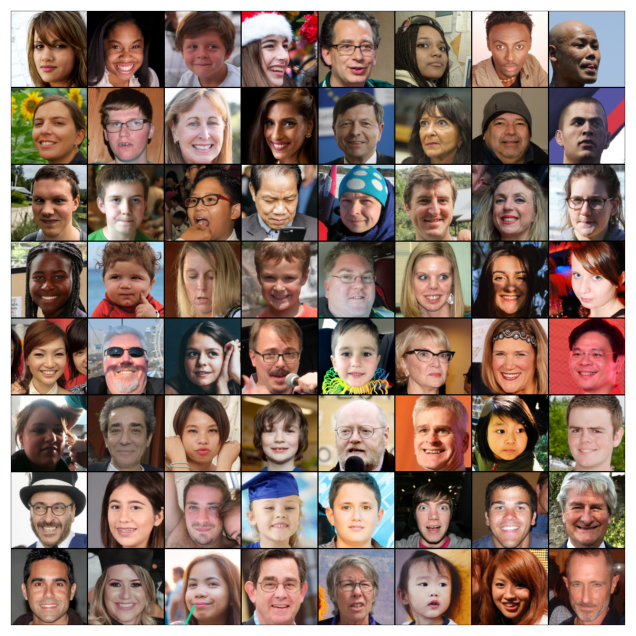

In [5]:
show_batch(dataloader,64)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:

дискриминатор принимает на вход изображение (тензор размера 3 x image_size x image_size) и выдает вероятность того, что изображение настоящее (тензор размера 1)

генератор принимает на вход тензор шумов размера latent_size x 1 x 1 и генерирует изображение размера 3 x image_size x image_size

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    
    nn.Linear(25,1),
    
    nn.Sigmoid())

#========================================================================
latent_size = 128
#========================================================================


generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() # приводит интенсивность цветов по каналам в нормальное состояние.[-1,1]
                # Если надо будет потом привести к диапазону 0-1 то накинем сигму
    # out: 3 x 64 x 64
)


torch.Size([85, 3, 64, 64])


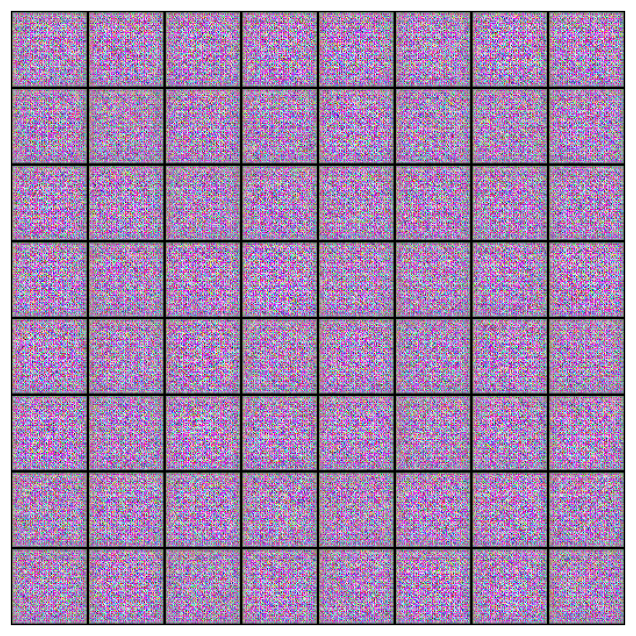

In [11]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [12]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [13]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса
  * обновляем веса ДИСКРИМИНАТОРА

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 1
  * предсказываем дискриминаторором, реальное это изображение или нет
  * считаем лосс и обновляем веса ГЕНЕРАТОРА


В качестве функции потерь берем бинарную кросс-энтропию

In [97]:
class custom_view(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 4, 1) 
    
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=6, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=5, stride=1, padding=0, bias=False),
    
    
   # custom_view(),
   # nn.Flatten(),
   
    
    nn.Sigmoid())

#========================================================================
latent_size = 128
#========================================================================


generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() # приводит интенсивность цветов по каналам в нормальное состояние.[-1,1]
                # Если надо будет потом привести к диапазону 0-1 то накинем сигму
    # out: 3 x 64 x 64
)


In [98]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



dataloader = DeviceDataLoader(dataloader, device)
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

lr = 0.0001
epochs = 80

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [99]:

model["discriminator"].train()
model["generator"].train()
torch.cuda.empty_cache()

# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

# Create optimizers
optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                      lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                  lr=lr, betas=(0.5, 0.999))
}

for epoch in range(epochs):
    loss_d_per_epoch = []
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []
    for real_images, _ in tqdm(dataloader):
        # Train discriminator
        # Clear discriminator gradients
        optimizer["discriminator"].zero_grad()
        # Pass real images through discriminator
        real_preds = model["discriminator"](real_images)
        real_targets = torch.ones(real_images.size(0), 1, device=device)
        real_loss = criterion["discriminator"](real_preds, real_targets)
        cur_real_score = torch.mean(real_preds).item()
        
        # Generate fake images
        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](latent)
        # Pass fake images through discriminator
        fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
        fake_preds = model["discriminator"](fake_images)
        fake_loss = criterion["discriminator"](fake_preds, fake_targets)
        cur_fake_score = torch.mean(fake_preds).item()
        real_score_per_epoch.append(cur_real_score)
        fake_score_per_epoch.append(cur_fake_score)
        # Update discriminator weights
        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer["discriminator"].step()
        loss_d_per_epoch.append(loss_d.item())
        # Train generator
        # Clear generator gradients
        optimizer["generator"].zero_grad()
        
        # Generate fake images
        latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](latent)
        
        # Try to fool the discriminator
        preds = model["discriminator"](fake_images)
        targets = torch.ones(batch_size, 1, device=device)
        loss_g = criterion["generator"](preds, targets)
        
        # Update generator weights
        loss_g.backward()
        optimizer["generator"].step()
        loss_g_per_epoch.append(loss_g.item())
        
    # Record losses & scores
    losses_g.append(np.mean(loss_g_per_epoch))
    losses_d.append(np.mean(loss_d_per_epoch))
    real_scores.append(np.mean(real_score_per_epoch))
    fake_scores.append(np.mean(fake_score_per_epoch))
    
    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, 
        losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

    # Save generated images
#     if epoch == epochs - 1:
#         save_samples(epoch+start_idx, fixed_latent, show=False)

# return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/37 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (340x1 and 4x1)

In [79]:
fake_images.shape

torch.Size([85, 3, 64, 64])

In [80]:
model["discriminator"](fake_images)

RuntimeError: Calculated padded input size per channel: (2 x 2). Kernel size: (5 x 5). Kernel size can't be greater than actual input size